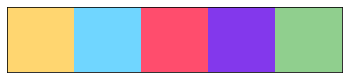

In [24]:
import os, tqdm, json, pickle, gc, zipfile, itertools, time, collections, sys, requests, schedule
import pandas as pd
import numpy as np
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


import matplotlib.pyplot as plt
import seaborn as sns


custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

def amex_metric_numpy(y_true, y_pred):

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

class Clipper():

    def __init__(self, clip_features):
        self.clip_features = clip_features

    def fit(self, df_features_train):  

        print('\t> clipping numeric features ...')

        self.d_clipper = {}
        # clip numberic outliers with IQR
        for key in tqdm.tqdm_notebook(self.clip_features):            

            # series without nan
            ser = df_features_train[key].dropna()

            # bounds
            q25, q75 = ser.quantile([.25, .75])
            iqr = q75-q25
            lower, higher = q25-1.5*iqr, q75+1.5*iqr

            self.d_clipper[key] = (lower, higher)

            del ser, lower, higher

        return self

    def transform(self, df_features_train):

        df_features_train_c = df_features_train.copy() 
        del df_features_train
        gc.collect()

        for key, (lower, higher) in tqdm.tqdm(self.d_clipper.items()):
            df_features_train_c[f'{key}__clipped'] = df_features_train_c[key].clip(lower, higher)

        return df_features_train_c


def amex_metric_official(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def get_metrics(model, X_eval, y_eval):

    """ calulate metrics """

    pred = model.predict(X_eval)
    pred_prob = model.predict_proba(X_eval)[:, 1]

    d= {}

    d['accuracy'] = accuracy_score(y_eval, pred)
    d['f1'] = f1_score(y_eval, pred)
    d['auc'] = roc_auc_score(y_eval, pred_prob)

    y_true, y_predprob = y_eval.to_frame('target'), pd.Series(pred_prob, index = y_eval.index).to_frame('prediction')
    d['amex_metric_official'] = amex_metric_official(y_true, y_predprob)

    d['tp'] = ((y_eval==1)&(pred==1)).sum()
    d['tn'] = ((y_eval==0)&(pred==0)).sum()
    d['fp'] = ((y_eval==0)&(pred==1)).sum()
    d['fn'] = ((y_eval==1)&(pred==0)).sum()

    d['importances'] = ser_imp = pd.Series(dict(zip(X_eval.columns, model.feature_importances_))).sort_values(ascending = False)

    return d

def eval_catboost(X_train, y_train, X_eval, y_eval, iterations, od_wait, verbose):

    """ evaluate model """

    cat_features = np.where(X_train.dtypes=='category')[0]

    params_c = {}
    params_c['iterations'] = iterations
    params_c['cat_features'] = cat_features
    params_c['od_type'] = 'Iter'
    params_c['od_wait'] = od_wait  
    params_c['eval_metric'] = 'AUC' 
    params_c['verbose'] = verbose

    model = cb.CatBoostClassifier(**params_c)
    model.fit(X_train, y_train, eval_set = (X_eval, y_eval))    
    best_iter = model.best_iteration_
    
    return model, best_iter, get_metrics(model, X_eval, y_eval) 

def catboost_drop_zero_importances(X_train, y_train, X_eval, y_eval,iterations):

    i=1
    while True:

        print('\t> iter#{}. n_features: {}'.format(i, X_train.shape[1]))

        model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,iterations=iterations, verbose=1)

        mask = model.feature_importances_>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            i+=1
    best_features = X_train.columns
    del X_train, X_eval
    gc.collect()

    return best_features

def get_catboost_eval_results(X_train, y_train, X_eval, y_eval, metric, iterations, n_repeats, seed):

    """ feature selection and eval results """    
          
    scores,features = [], []
    i = 1       
    while True:
        
        model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,iterations=iterations, verbose=1)
        
        L_perm_imp = []
        for _ in tqdm.tqdm(range(n_repeats)):
            d_perm_imp = permutation_importance(model, X_eval, y_eval, scoring=metric, n_jobs=-1, n_repeats = 1, random_state = seed+_)    
            L_perm_imp.append(d_perm_imp['importances_mean'])
        mean_perm_imp = np.c_[L_perm_imp].mean(0)

        mask = mean_perm_imp>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,iterations=iterations, verbose=0)
            
            score= d_eval_results['amex_metric_official']
            keys=X_train.columns

            scores.append(score)
            features.append(keys)

            print('\t> amex score: {}'.format(score))
            i+=1

    return {
        'iterations':best_iter,        
        'eval_results':d_eval_results,
        'scores':scores,
        'features':features
    }

def prepare_data(filename_train):

    # train data
    df_train = pd.read_feather(os.path.join(PATH_TO_DATA, filename_train))
    
    try:        
        # drop target, order by date
        df_train = df_train.drop(TARGET_KEY, 1).sort_values(DATE_KEY).reset_index(drop = True)
    except:
        # order by date
        df_train = df_train.sort_values(DATE_KEY).reset_index(drop = True)

    # add date features
    # timestamp
    df_train['timestamp'] = df_train[DATE_KEY].apply(lambda row: row.timestamp()) / 1e9
    # year
    df_train['year'] = df_train[DATE_KEY].dt.year
    # month
    df_train['month'] = df_train[DATE_KEY].dt.month 
    # day
    df_train['day'] = df_train[DATE_KEY].dt.day    
    # weekday
    df_train['weekday'] = df_train[DATE_KEY].dt.weekday

    return df_train

def extract_features(df_train):

    # split customers into buckets
    unique_id_key = df_train[ID_KEY].value_counts().index
    l_batches = np.array_split(unique_id_key, np.int32(np.ceil(len(unique_id_key) / BATCH_SIZE)))

    df_features_train = pd.DataFrame()

    # for each batch
    for batch in tqdm.tqdm_notebook(l_batches[:1]):

        # subset
        df = df_train[df_train[ID_KEY].isin(batch)]

        # add features
        rows = []
        for id, subdf in tqdm.tqdm_notebook(df.groupby(ID_KEY)):

            # pad customer
            subdf_padded = pd.concat([add_rows(subdf, MAX_GROUP_SIZE, NUM_FEATURES), subdf[NUM_FEATURES]])

            # features
            d = {ID_KEY:id}
            d.update(subdf[CAT_FEATURES].iloc[0].to_dict())
            d['count'] = len(subdf)            

            # number
            for key in NUM_FEATURES:

                feature_values = subdf_padded[key].values
                feature_names = D_FEATURE_NAME[key]

                d.update(dict(zip(feature_names, feature_values)))

                d[f'{key}__mean'] = feature_values.mean()
                d[f'{key}__min'] = feature_values.min()
                d[f'{key}__max'] = feature_values.max()                

                feature_values_fill = feature_values.copy()
                feature_values_fill[np.isnan(feature_values_fill)] = 0
                d[f'{key}__diff_mean'] = np.diff(feature_values_fill).mean()

                del feature_names, feature_values, feature_values_fill           
            
            rows.append(d)
            del d, subdf_padded, subdf

        # features subset
        subdf_features = pd.DataFrame.from_records(rows)
        del rows

        # add
        df_features_train = df_features_train.append(subdf_features)
        del subdf_features 

    return df_features_train  


def add_rows(subdf, MAX_GROUP_SIZE, NUM_FEATURES):
    ''' pad data for customer to max records size'''
    size = subdf.shape[0]
    df_add = pd.DataFrame(np.full((MAX_GROUP_SIZE-size, len(NUM_FEATURES)), np.nan), columns = NUM_FEATURES)    
    return df_add

def apply_label_encoder_and_scaler(df_features_train):

    df_features_train = df_features_train.set_index(ID_KEY)
    # numbers
    num_features = df_features_train.drop(CAT_FEATURES, 1).columns

    # scale numbers
    scaler = MinMaxScaler()
    d_scaler = {}
    for key in tqdm.tqdm(num_features):
        df_features_train[key] = scaler.fit_transform(df_features_train[[key]]).flatten()
        d_scaler[key] = scaler
    df_features_train[num_features] = df_features_train[num_features].fillna(DEFAULT_VALUE)

    # encode categories with label
    label_encoder = LabelEncoder()
    d_label_encoder = {}
    for key in CAT_FEATURES:
        try:
            df_features_train[key] = df_features_train[key].astype('float').fillna(-1)
        except:
            df_features_train[key] = label_encoder.fit_transform(df_features_train[key].astype('str'))
            d_label_encoder[key] = label_encoder

    # one hot encoders
    onehot_encoder = OneHotEncoder(handle_unknown='ignore')

    for ts in ['year','month','day','weekday']:
        keys= df_features_train.columns[df_features_train.columns.str.contains(ts)&df_features_train.columns.str.contains('ts')].tolist()
        CAT_FEATURES.extend(keys)

    d_onehot_encoder = {}
    for key in CAT_FEATURES:
        ohe_arr = onehot_encoder.fit_transform(df_features_train[[key]]).todense()
        d_onehot_encoder[key] = onehot_encoder
        new_keys = [f'{key}__{i+1}' for i in range(ohe_arr.shape[1])]
        df_features_preprocessed_train= pd.concat([
            df_features_train,
            pd.DataFrame(ohe_arr, columns = new_keys, index = df_features_train.index)
        ], 1)
        
    df_features_train = df_features_train.convert_dtypes()    

    return df_features_train, d_label_encoder, d_onehot_encoder, d_scaler

class MetaFeaturesExtractor():

    def __init__(self, model, meta_dir):
        self.model = model
        self.meta_dir = meta_dir

        if not(os.path.isdir(self.meta_dir)):
            os.mkdir(self.meta_dir)
        else:
            raise ValueError('directory exists')

    def fit(self, X_train, y_train):       

        self.index= X_train.index
        self.ser_oof_proba= pd.Series(np.repeat(np.nan, len(self.index)),index=self.index)

        
        for i, (tr_idx, val_idx) in tqdm.tqdm(enumerate(KF5.split(X_train, y_train)), total = KF5.n_splits):

            self.model.fit(X_train.iloc[tr_idx], y_train.iloc[tr_idx])

            with open(os.path.join(self.meta_dir, f'model{i+1}.pickle'), 'wb') as f:
                pickle.dump(self.model, f)

            oof_proba=self.model.predict_proba(X_train.iloc[val_idx])[:, 1]
            self.ser_oof_proba.loc[self.index[val_idx]] = oof_proba

        return self

    def transform(self, X_train):

        if len(self.index)==len(X_train.index):
            if np.all(self.index==X_train.index):
                return self.ser_oof_proba.values
        else:
            l = []
            for fnm in os.listdir(self.meta_dir):
                with open(os.path.join(self.meta_dir, fnm), 'rb') as f:
                    model = pickle.load(f)
                l.append(model.predict_proba(X_train)[:, 1])
            arr = np.c_[l].T.mean(1)
            del l
            gc.collect()
            return arr

def drop_useless_features(model, X_train,y_train, verbose):

    X_train_c = X_train.copy()

    i = 1
    while True:

        if verbose:
            print('\t> iter#{}. selected count: {}'.format(i, X_train_c.shape[1]))
        
        model.fit(X_train_c, y_train)
        
        try:
            mask = model.coef_.flatten()!=0
        except:
            mask = model.feature_importances_.flatten()!=0

        if np.all(mask):
            break
        else:
            X_train_c = X_train_c.loc[:, mask]
            i+=1

    best_features = X_train_c.columns
    del X_train_c
    gc.collect()
    
    return best_features

In [2]:
# dir with data
PATH_TO_DATA= 'data'

# seed
SEED = 13

# target key
TARGET_KEY='target'

# customer id key
ID_KEY = 'customer_ID'

DATE_KEY = 'S_2'

# split
TEST_SIZE = .1

# percentiles (10)
PS = np.linspace(2.5, 97.5, 10)

# batch size
BATCH_SIZE = 1000

DEFAULT_VALUE = -1

# categorial features
CAT_FEATURES = [
    'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116',
    'D_117', 'D_120', 'D_126'
]

# numeric features
NUM_FEATURES = [
    'P_2','D_39','B_1','B_2','R_1','S_3','D_41','B_3','D_42','D_43','D_44','B_4',
    'D_45','B_5','R_2','D_46','D_47','D_48','D_49','B_6','B_7','B_8','D_50','D_51',
    'B_9','R_3','D_52','P_3','B_10','D_53','S_5','B_11','S_6','D_54','R_4','S_7',
    'B_12','S_8','D_55','D_56','B_13','R_5','D_58','S_9','B_14','D_59','D_60','D_61',
    'B_15','S_11','D_62','D_65','B_16','B_17','B_18','B_19','B_20','S_12','R_6','S_13',
    'B_21','D_69','B_22','D_70','D_71','D_72','S_15','B_23','D_73','P_4','D_74','D_75',
    'D_76','B_24','R_7','D_77','B_25','B_26','D_78','D_79','R_8','R_9','S_16','D_80','R_10',
    'R_11','B_27','D_81','D_82','S_17','R_12','B_28','R_13','D_83','R_14','R_15','D_84',
    'R_16','B_29','S_18','D_86','D_87','R_17','R_18','D_88','B_31','S_19','R_19','B_32',
    'S_20','R_20','R_21','B_33','D_89','R_22','R_23','D_91','D_92','D_93','D_94','R_24',
    'R_25','D_96','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_105',
    'D_106','D_107','B_36','B_37','R_26','R_27','D_108','D_109','D_110','D_111','B_39',
    'D_112','B_40','S_27','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124',
    'D_125','D_127','D_128','D_129','B_41','B_42','D_130','D_131','D_132','D_133','R_28',
    'D_134','D_135','D_136','D_137','D_138','D_139','D_140','D_141','D_142','D_143','D_144',
    'D_145',
    'timestamp','year','month','day','weekday'
]

# maximum amount of records for each customer
MAX_GROUP_SIZE = 13

# feature names
D_FEATURE_NAME = {}
for key in NUM_FEATURES:    
    D_FEATURE_NAME[key] = [f'{key}__ts_{i+1}' for i in range(MAX_GROUP_SIZE)]

KF5 = KFold(5, shuffle = True, random_state = SEED)

In [3]:
# load data, prepare
df_train = prepare_data('train_data.ftr')

# extract features
df_features_train = extract_features(df_train)
df_features_train.to_pickle('df_features_train.pickle')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
df_features_preprocessed_train, d_label_encoder, d_onehot_encoder, d_scaler= apply_label_encoder_and_scaler(df_features_train)
del df_features_train
gc.collect()

100%|██████████| 3095/3095 [00:06<00:00, 445.88it/s]


2160

In [5]:
d_label_encoder

{'D_63': LabelEncoder(), 'D_64': LabelEncoder()}

In [6]:
d_onehot_encoder

{'D_63': OneHotEncoder(handle_unknown='ignore'),
 'D_64': OneHotEncoder(handle_unknown='ignore'),
 'D_66': OneHotEncoder(handle_unknown='ignore'),
 'D_68': OneHotEncoder(handle_unknown='ignore'),
 'B_30': OneHotEncoder(handle_unknown='ignore'),
 'B_38': OneHotEncoder(handle_unknown='ignore'),
 'D_114': OneHotEncoder(handle_unknown='ignore'),
 'D_116': OneHotEncoder(handle_unknown='ignore'),
 'D_117': OneHotEncoder(handle_unknown='ignore'),
 'D_120': OneHotEncoder(handle_unknown='ignore'),
 'D_126': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_1': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_2': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_3': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_4': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_5': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_6': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_7': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_8': OneHotEncoder(handle_unknown='ignore'),
 'year__ts_9': O

In [7]:
d_scaler

{'count': MinMaxScaler(),
 'P_2__ts_1': MinMaxScaler(),
 'P_2__ts_2': MinMaxScaler(),
 'P_2__ts_3': MinMaxScaler(),
 'P_2__ts_4': MinMaxScaler(),
 'P_2__ts_5': MinMaxScaler(),
 'P_2__ts_6': MinMaxScaler(),
 'P_2__ts_7': MinMaxScaler(),
 'P_2__ts_8': MinMaxScaler(),
 'P_2__ts_9': MinMaxScaler(),
 'P_2__ts_10': MinMaxScaler(),
 'P_2__ts_11': MinMaxScaler(),
 'P_2__ts_12': MinMaxScaler(),
 'P_2__ts_13': MinMaxScaler(),
 'P_2__mean': MinMaxScaler(),
 'P_2__min': MinMaxScaler(),
 'P_2__max': MinMaxScaler(),
 'P_2__diff_mean': MinMaxScaler(),
 'D_39__ts_1': MinMaxScaler(),
 'D_39__ts_2': MinMaxScaler(),
 'D_39__ts_3': MinMaxScaler(),
 'D_39__ts_4': MinMaxScaler(),
 'D_39__ts_5': MinMaxScaler(),
 'D_39__ts_6': MinMaxScaler(),
 'D_39__ts_7': MinMaxScaler(),
 'D_39__ts_8': MinMaxScaler(),
 'D_39__ts_9': MinMaxScaler(),
 'D_39__ts_10': MinMaxScaler(),
 'D_39__ts_11': MinMaxScaler(),
 'D_39__ts_12': MinMaxScaler(),
 'D_39__ts_13': MinMaxScaler(),
 'D_39__mean': MinMaxScaler(),
 'D_39__min': MinMa

In [8]:
# train target
df_target_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_labels.csv')).set_index(ID_KEY)

In [9]:
# customers in train (ordered by date)
id_train = df_train[ID_KEY].unique()

# customers in feature table
id2use = []
for i in df_features_preprocessed_train.index:
    if i in id_train:
        id2use.append(i)

# order table by date
df_features_preprocessed_train = df_features_preprocessed_train.loc[id2use]
df_target_train = df_target_train.loc[id2use]

In [10]:
X = df_features_preprocessed_train.copy()
del df_features_preprocessed_train
gc.collect()

y = df_target_train['target'].astype('int')
del df_target_train
gc.collect()

X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size = TEST_SIZE)
del X, y
gc.collect()

with open('split.pickle', 'wb') as f:
    pickle.dump((X_train, X_eval, y_train, y_eval),f)

In [11]:
X_train.head()

,D_63,D_64,D_66,D_68,B_30,B_38,D_114,D_116,D_117,D_120,...,weekday__ts_8,weekday__ts_9,weekday__ts_10,weekday__ts_11,weekday__ts_12,weekday__ts_13,weekday__mean,weekday__min,weekday__max,weekday__diff_mean
customer_ID,,,,,,,,,,,,,,,,,,,,,
866dcd683c3c00081359dfb9942891b9bd9d234f40d966aff91524a66a1744a6,1,3,-1,6,1,4,0,0,-1,0,...,0.500000,0.333333,0.500000,0.833333,0.833333,0.333333,0.52,0.000000,1.000000,0.583333
ed38a56ae31b39b9a64cdabe97b44ca56ee599aaed8c263fc696a3c850e0b572,1,3,1,4,0,2,0,0,4,0,...,0.833333,0.333333,0.500000,0.166667,0.166667,0.666667,0.36,0.000000,0.666667,0.750000
24eb6820ba50969476cedf80f4c738b5f2aa9f2d7d5fb0d65a1fbb44051a2d57,1,2,-1,6,0,2,1,0,4,0,...,0.333333,0.666667,0.000000,0.500000,0.500000,0.833333,0.44,0.000000,0.666667,0.833333
bb913f8de8e7bbf4c5d44c17514a252378ce27cf9acf440488866e7e2a67cf24,1,2,-1,6,0,1,1,0,4,0,...,0.833333,0.166667,0.666667,0.000000,0.000000,0.500000,0.32,0.000000,0.666667,0.583333
05126186633dfcc13397be27081d5f0b1e2502ea5ab1f23b35ca362b123a4c4b,1,2,-1,6,0,2,1,0,4,0,...,0.166667,0.500000,0.833333,0.833333,0.333333,0.333333,0.46,0.333333,0.666667,0.333333


In [12]:
# GENERATING BASE MODELS: LINEAR, TREE, FOREST, KNN, BOOSTINGS
# SELECT FEATURES FOR EACH BASE MODEL AND MAKE META FEATURES

# base logits
logits = []
for C in [.001, .1, 1, 10, 100]:
    logits.append(LogisticRegression(C=C, penalty='l1', random_state = SEED, solver = 'liblinear', n_jobs=-1))

# base trees
trees = []
for max_depth in [2, 5, 10, -1]:
    for min_samples_split in [2, 20, 200]:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        extratree = ExtraTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
        trees.extend([tree, extratree])

# base forests
forests = []
for depth in [20, 40, 60, 100]:
    forest = RandomForestClassifier(max_depth = depth,  random_state = SEED, n_jobs=-1)
    extratrees = ExtraTreesClassifier(max_depth=max_depth, min_samples_split=min_samples_split)
    forests.extend([forest, extratrees]) 

In [17]:
# meta features
L_meta_train, L_meta_eval = [], []

# for each base logit
for i, logit in tqdm.tqdm_notebook(enumerate(logits), total = len(logits)):

    print('---------------------------------------------------------------------------------------------')
    print(logit)

    # select features
    best_features = drop_useless_features(logit, X_train,y_train, verbose=1)

    # filtered tables
    X_train_c, X_eval_c = X_train[best_features], X_eval[best_features]

    # meta features extractor
    # base model, directory with fitted base models
    meta_logit = MetaFeaturesExtractor(model=logit, meta_dir=f'meta/logit_v{i+1}')
    meta_logit.fit(X_train_c, y_train)

    # meta features for train, eval sets
    L_meta_train.append(pd.Series(meta_logit.transform(X_train_c), index = X_train.index).to_frame(f'logit_v{i+1}'))
    L_meta_eval.append(pd.Series(meta_logit.transform(X_eval_c), index = X_eval.index).to_frame(f'logit_v{i+1}'))

    del X_train_c, X_eval_c
    gc.collect()

X_logit_meta_train= pd.concat(L_meta_train,1)
X_logit_meta_eval = pd.concat(L_meta_eval,1)

del L_meta_train, L_meta_eval
gc.collect()    

  0%|          | 0/5 [00:00<?, ?it/s]

---------------------------------------------------------------------------------------------
LogisticRegression(C=0.001, n_jobs=-1, penalty='l1', random_state=13,
                   solver='liblinear')
	> iter#1. selected count: 3106
	> iter#2. selected count: 1


100%|██████████| 5/5 [00:00<00:00, 192.83it/s]


---------------------------------------------------------------------------------------------
LogisticRegression(C=0.1, n_jobs=-1, penalty='l1', random_state=13,
                   solver='liblinear')
	> iter#1. selected count: 3106
	> iter#2. selected count: 30
	> iter#3. selected count: 28


100%|██████████| 5/5 [00:00<00:00, 82.19it/s]


---------------------------------------------------------------------------------------------
LogisticRegression(C=1, n_jobs=-1, penalty='l1', random_state=13,
                   solver='liblinear')
	> iter#1. selected count: 3106
	> iter#2. selected count: 202
	> iter#3. selected count: 178
	> iter#4. selected count: 176


100%|██████████| 5/5 [00:00<00:00, 13.14it/s]


---------------------------------------------------------------------------------------------
LogisticRegression(C=10, n_jobs=-1, penalty='l1', random_state=13,
                   solver='liblinear')
	> iter#1. selected count: 3106
	> iter#2. selected count: 359
	> iter#3. selected count: 254
	> iter#4. selected count: 241
	> iter#5. selected count: 234


100%|██████████| 5/5 [00:00<00:00, 10.66it/s]


---------------------------------------------------------------------------------------------
LogisticRegression(C=100, n_jobs=-1, penalty='l1', random_state=13,
                   solver='liblinear')
	> iter#1. selected count: 3106
	> iter#2. selected count: 768
	> iter#3. selected count: 514
	> iter#4. selected count: 447
	> iter#5. selected count: 416
	> iter#6. selected count: 405
	> iter#7. selected count: 394
	> iter#8. selected count: 390
	> iter#9. selected count: 379
	> iter#10. selected count: 370
	> iter#11. selected count: 364
	> iter#12. selected count: 361
	> iter#13. selected count: 358
	> iter#14. selected count: 355
	> iter#15. selected count: 354
	> iter#16. selected count: 347
	> iter#17. selected count: 345
	> iter#18. selected count: 344
	> iter#19. selected count: 343
	> iter#20. selected count: 341
	> iter#21. selected count: 339
	> iter#22. selected count: 336
	> iter#23. selected count: 332
	> iter#24. selected count: 329
	> iter#25. selected count: 328
	> iter

100%|██████████| 5/5 [00:00<00:00, 16.92it/s]


In [22]:
X_logit_meta_train

,logit_v1,logit_v2,logit_v3,logit_v4,logit_v5
customer_ID,,,,,
866dcd683c3c00081359dfb9942891b9bd9d234f40d966aff91524a66a1744a6,0.497400,0.682839,0.985387,9.999590e-01,9.999468e-01
ed38a56ae31b39b9a64cdabe97b44ca56ee599aaed8c263fc696a3c850e0b572,0.499346,0.041219,0.002420,2.434757e-06,5.691208e-09
24eb6820ba50969476cedf80f4c738b5f2aa9f2d7d5fb0d65a1fbb44051a2d57,0.489745,0.023906,0.000216,2.587165e-07,1.414587e-12
bb913f8de8e7bbf4c5d44c17514a252378ce27cf9acf440488866e7e2a67cf24,0.489745,0.019895,0.003671,2.372775e-05,1.610918e-07
05126186633dfcc13397be27081d5f0b1e2502ea5ab1f23b35ca362b123a4c4b,0.497400,0.026427,0.000489,9.218269e-07,4.184429e-09
...,...,...,...,...,...
cd6353891f18ec617712173f306d86f0637b649661b871795c2dc41c6dfafba3,0.499020,0.327310,0.556593,8.495469e-01,9.983177e-01
072675529946f13b46c717a3e93b6ae0f1f8b7b8f5da5a09fd33d2833bd51467,0.499020,0.040062,0.004954,6.774362e-04,9.217884e-05
d279a70e7a381beaa82819bd6f2b7bc02a525544e0988233dc061892d4773bae,0.489745,0.083579,0.006877,1.944469e-05,2.516408e-06


In [23]:
X_logit_meta_eval

,logit_v1,logit_v2,logit_v3,logit_v4,logit_v5
customer_ID,,,,,
a608cc0b4af6d7f987c960a19f67db45d4479a45227ef15885fbdedec8f031b5,0.496484,0.025797,0.005450,8.855394e-04,2.783749e-05
1f91afbf114153eddcd51fe92f9194c6679064a9629e842083b3d9a5e31cd2ab,0.497656,0.766946,0.861644,7.948668e-01,3.581156e-01
2494b4260db1f0f744c091fce412302a7582cd396f76353ea958b2ac22f5d0d7,0.497070,0.667861,0.510989,3.631852e-01,7.668888e-01
414b7ad2bc6c190c74097003fc87d373e22ceca14aaccaa37bb5f821d84e73e3,0.496484,0.029388,0.001033,4.473368e-06,7.203335e-09
594d5679692bf27326edfeb7254e679225632a138aed84bd4fe3302a78ca5a24,0.497656,0.029832,0.002506,1.131893e-05,6.550740e-07
...,...,...,...,...,...
1e4c96415e0bf7c3b8542bb8c0b3e32c3c2534d8c76f5bfaf73b9689b5e653d6,0.498242,0.033268,0.000357,3.390679e-07,1.117300e-09
a703d848b38773e18afdd89675ff6d1a1a4d7dab23726bb5dc65ef5f9daad0ce,0.497070,0.047391,0.008910,1.996775e-03,1.883323e-03
adfc8413310c7a253e6af5da7e911cb721f76dd9f2e0e37059afd51b707f7aa4,0.497070,0.076401,0.007425,2.411286e-05,1.147306e-07
